In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
# sample_submission = pd.read_csv('sample_submission.csv')

# EDA

In [ ]:
df = train.copy()

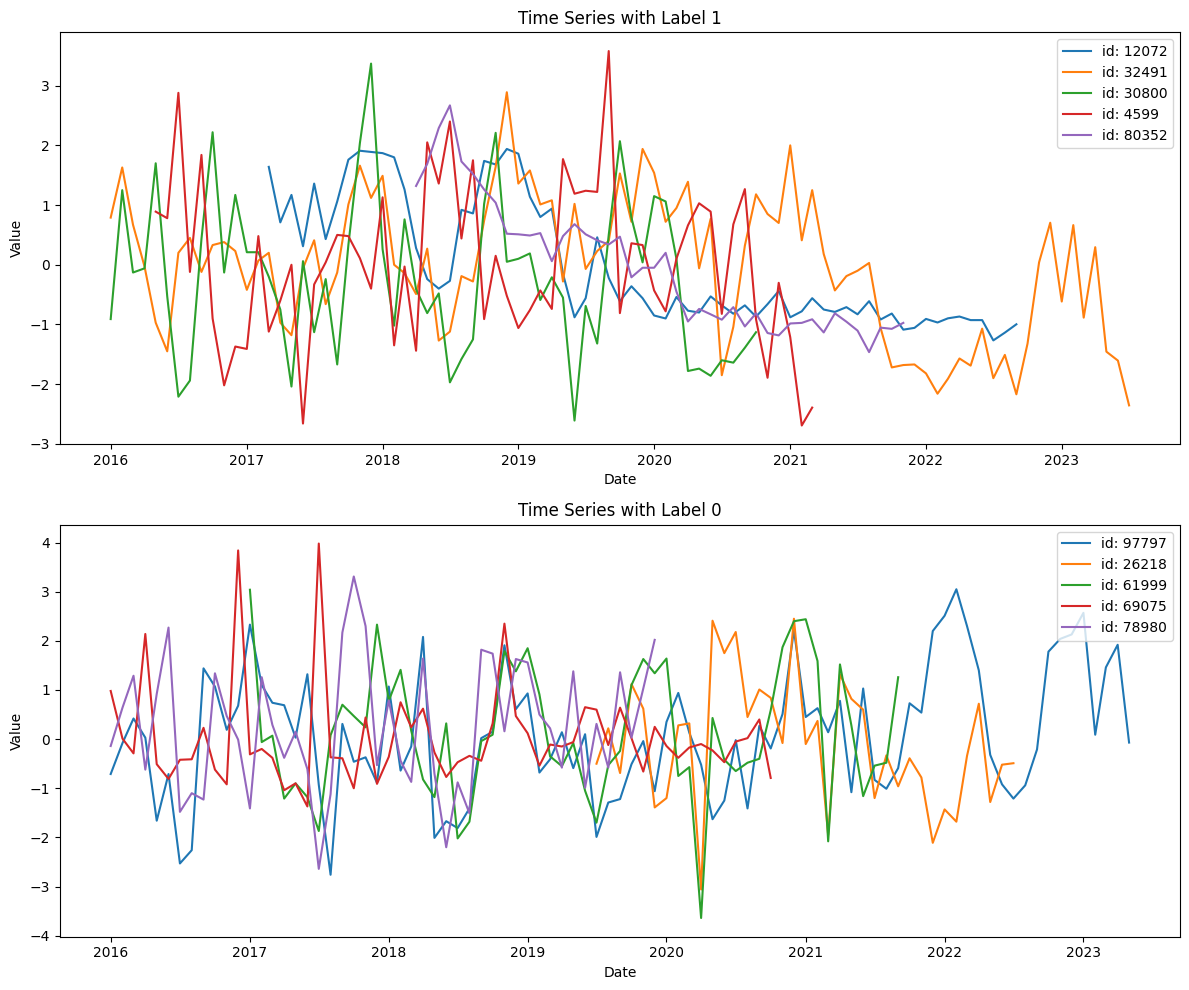

In [ ]:
df_label_1 = df[df['label'] == 1].sample(n=5, random_state=42)
df_label_0 = df[df['label'] == 0].sample(n=5, random_state=42)

# Функция для визуализации временных рядов
def plot_time_series(data, label, ax):
    for i, row in data.iterrows():
        ax.plot(row['dates'], row['values'], label=f'id: {row["id"]}')
    ax.set_title(f'Time Series with Label {label}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Визуализация 10 временных рядов с меткой 1
plot_time_series(df_label_1, label=1, ax=axes[0])

# Визуализация 10 временных рядов с меткой 0
plot_time_series(df_label_0, label=0, ax=axes[1])

# Отображение легенды и графиков
for ax in axes:
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


Видим, что сложно выделить какие то зависимости чисто по временному ряду.

Также видим, что некоторые ряды "длиннее" - нет фиксированного временного интервала(как начала, так и конца)

In [ ]:
df['label'].value_counts()

,count
label,
0.0,57820
1.0,22180


Временных рядов класса "1" примерно в два раза больше, но дисбаланс не слишком большой - ничего критичного.

In [ ]:
df.isnull().sum()

,0
id,0
dates,0
values,0
label,0


Нет пропусков.

Но дальше мы увидим, что пропуски будут обнаружены непосредственно в массивах.

<Axes: xlabel='label', ylabel='values'>

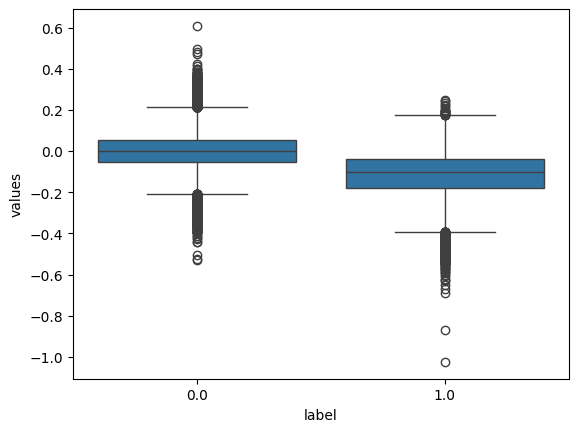

In [ ]:
sns.boxplot(x='label', y=df['values'].apply(np.mean), data=df)

Тут видно, что средние значения двух классов довольно слабо отличаются, имеют одинаковые размахи(+-). Но отличие может быть и значимо для классификатора.

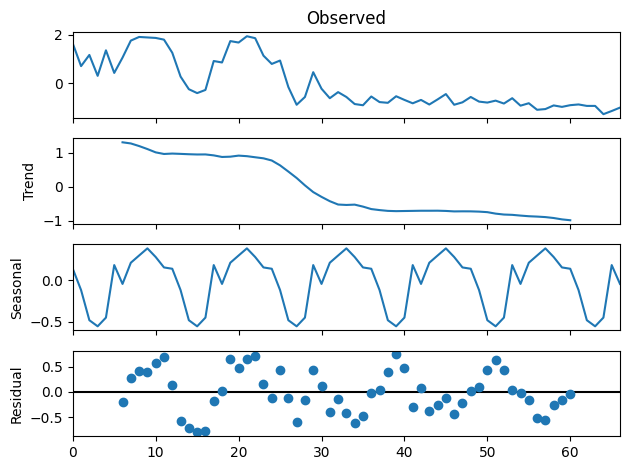

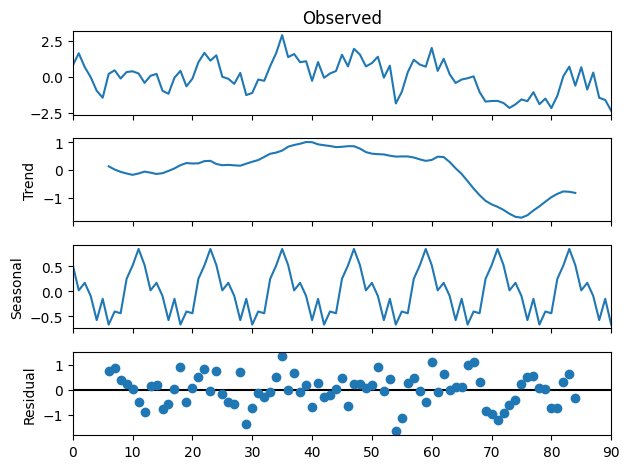

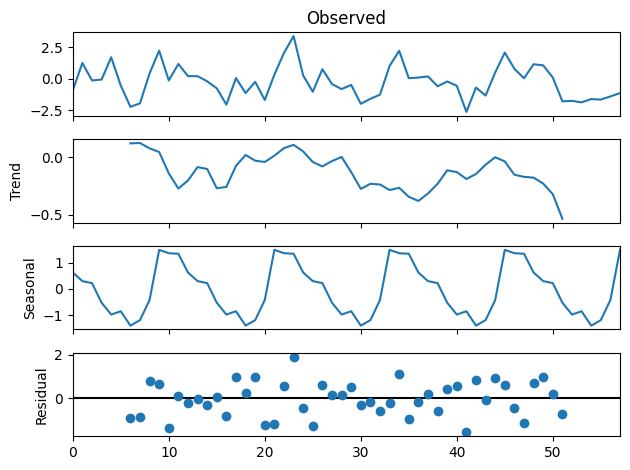

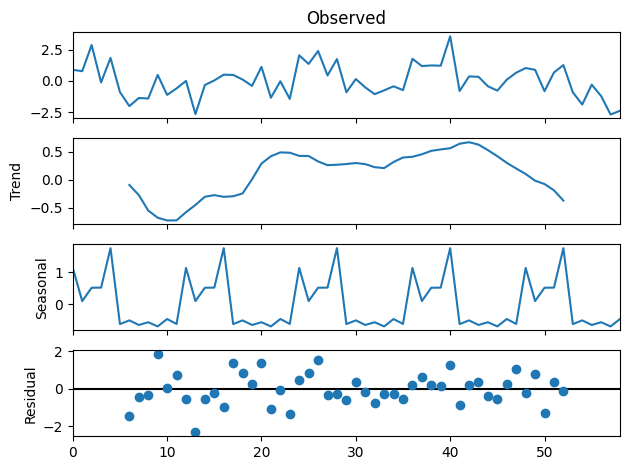

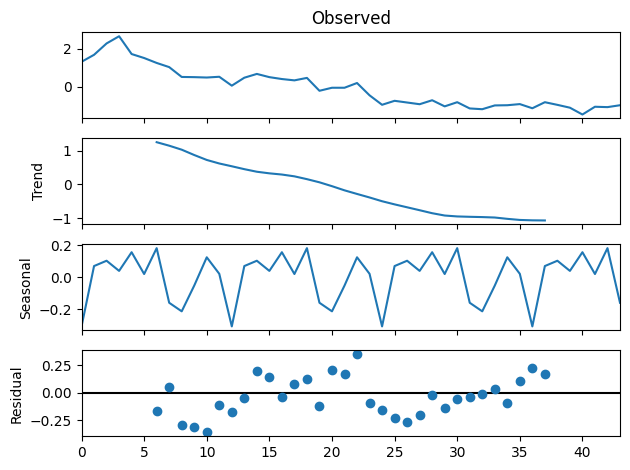

In [ ]:
for i, row in df_label_1.iterrows():
    result = seasonal_decompose(row['values'], period=12, model='additive')
    result.plot()
    plt.show()

Хотелось тут выделить как то тренд и сезонные компоненты для класса 1, но видим, что тренд в 5 рандомных рядах абсолютно разный, как и сезонности - возможно эти компоненты не особо помогут нам в классификации.

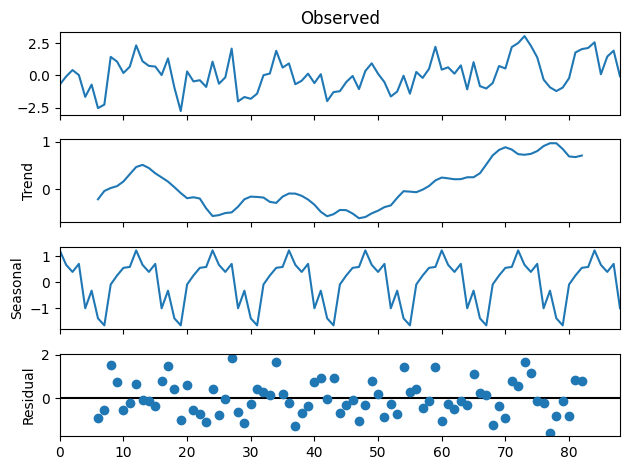

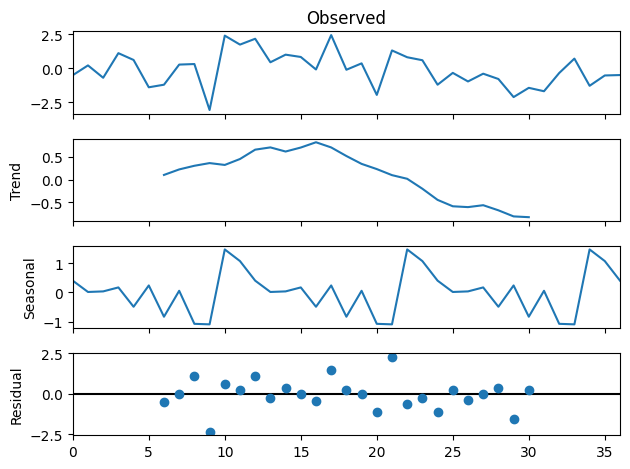

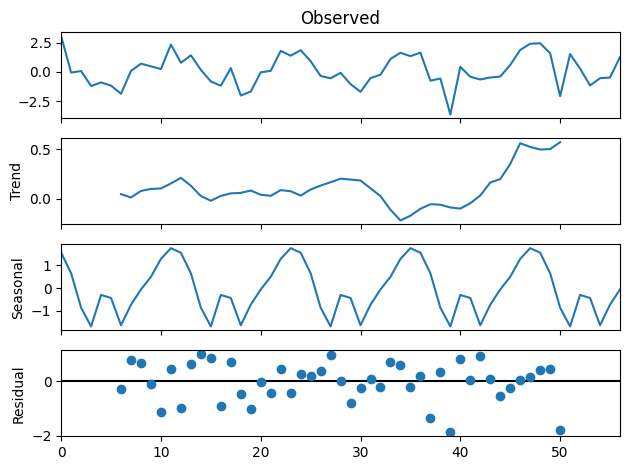

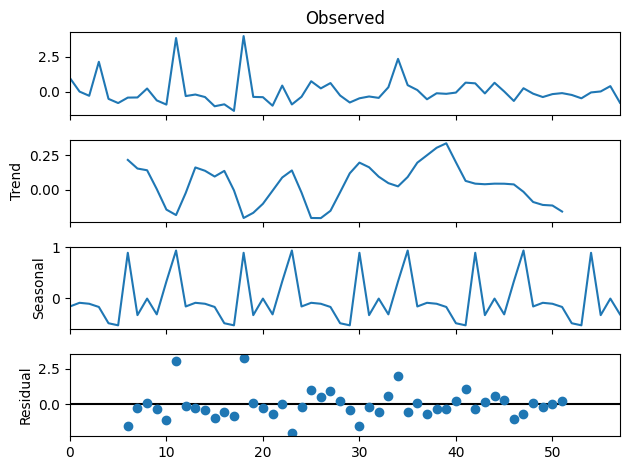

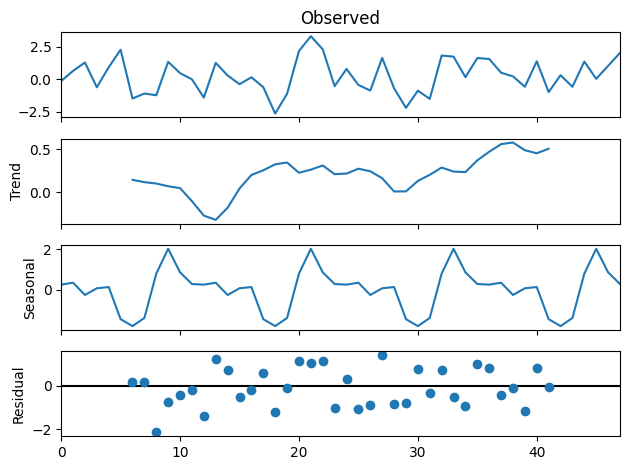

In [ ]:
for i, row in df_label_0.iterrows():
    result = seasonal_decompose(row['values'], period=12, model='additive')
    result.plot()
    plt.show()

Аналогично и для метки 0

In [ ]:
for i, row in df_label_1.iterrows():
    result = adfuller(row['values'])
    print(f'Time Series {i}: p-value = {result[1]}')

Time Series 72367: p-value = 0.6617959208627431
Time Series 46273: p-value = 0.05540910758335947
Time Series 45600: p-value = 2.5547282366579586e-05
Time Series 24295: p-value = 0.010286226812527735
Time Series 63278: p-value = 0.006312242801543079


In [ ]:
for i, row in df_label_0.iterrows():
    result = adfuller(row['values'])
    print(f'Time Series {i}: p-value = {result[1]}')

Time Series 70712: p-value = 0.0001571069153886406
Time Series 76991: p-value = 0.36957927270123453
Time Series 39839: p-value = 0.5929174590131892
Time Series 40559: p-value = 0.0007315083740680247
Time Series 69326: p-value = 4.711191565319886e-06


Тут мы видим, что для обеих меток класса характерно то, что некоторые ряды стационарные, некоторые нестационарные.

In [ ]:
df['length'] = df['values'].apply(len)
print(df['length'].describe())

count    80000.000000
mean        64.442650
std         15.399473
min         36.000000
25%         52.000000
50%         62.000000
75%         76.000000
max         97.000000
Name: length, dtype: float64


Тут мы можем видеть распределение "ддин" рядов.

Вообще, то что у нас длины отличаются не дает нам использовать RNN архитектуры, не меняя как то датасет.


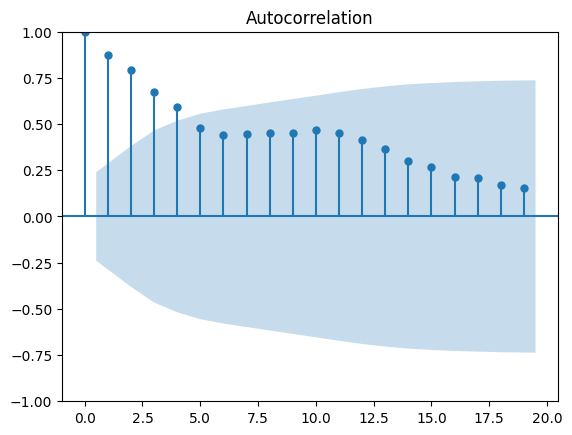

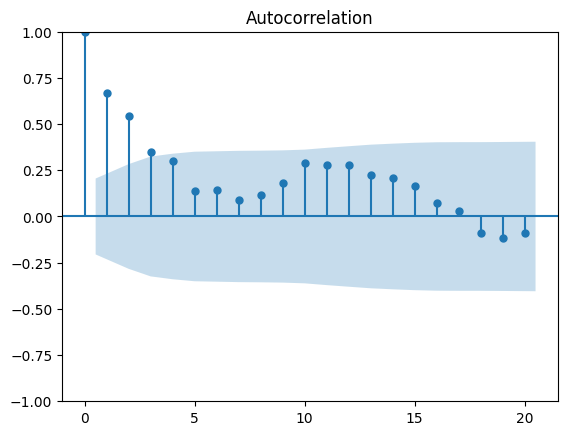

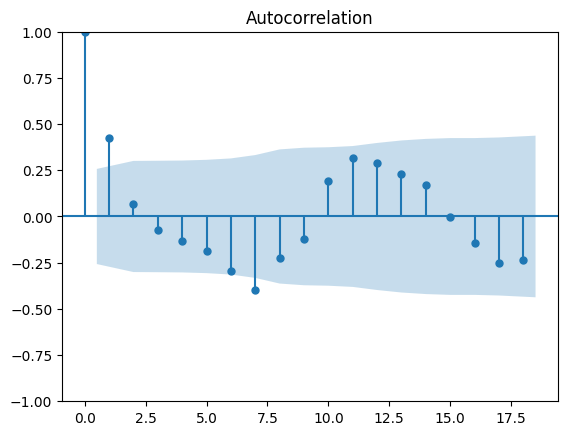

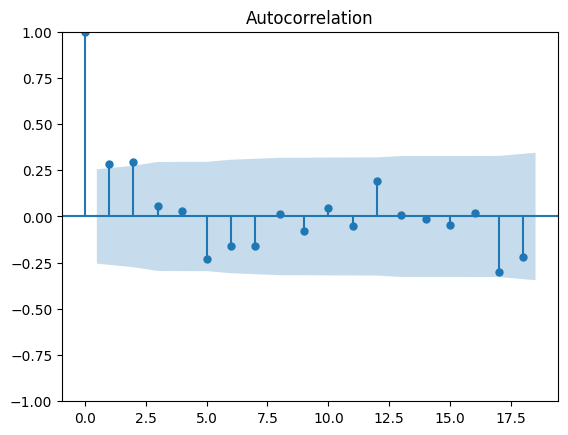

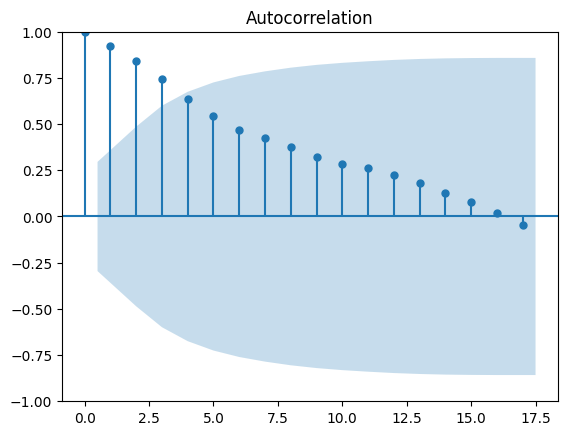

In [ ]:
for i, row in df_label_1.iterrows():
    plot_acf(row['values'])
    plt.show()

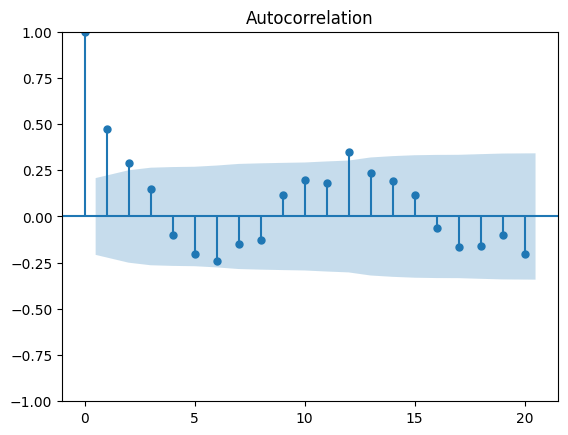

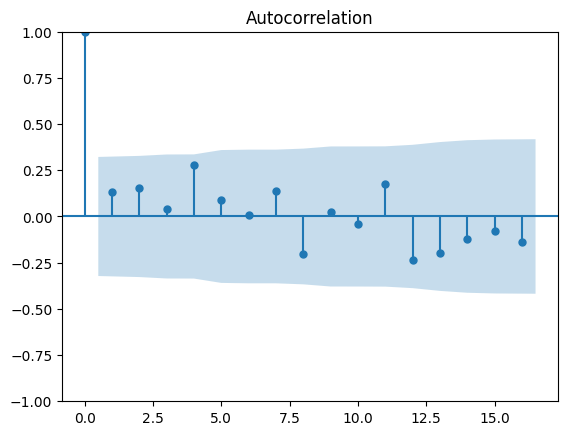

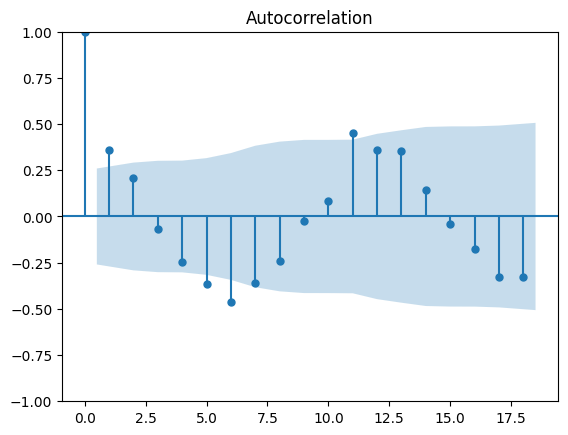

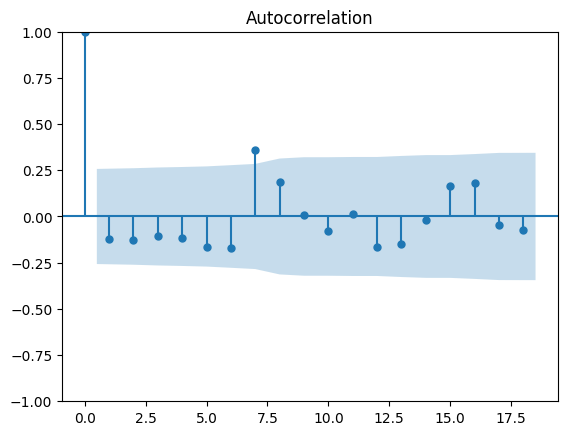

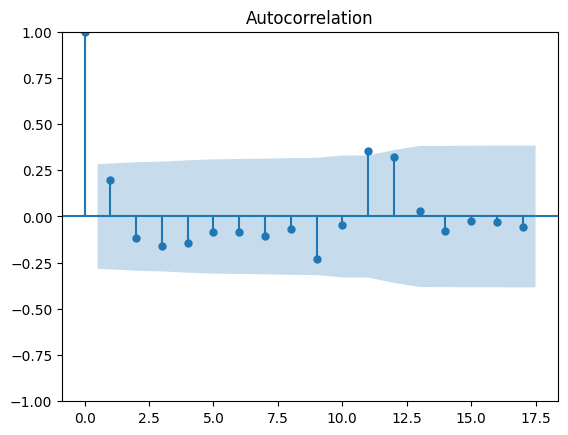

In [ ]:
for i, row in df_label_0.iterrows():
    plot_acf(row['values'])
    plt.show()

Какое то однообразное поведение для автокорреляционных функций по классам тоже выделить нельзя - это дополнение к гипотезе о том, что стат методы нам врядли помогут в классификации. Будем надеятся на мощь катбуста.

# CatBoost

In [5]:
!pip install catboost

In [6]:
def remove_rows_with_nan(df):
    # Проверяем, есть ли в каждом массиве NaN
    df_clean = df[~df['values'].apply(lambda x: np.isnan(x).any())].reset_index(drop=True)
    return df_clean

# Удаляем строки с NaN в массивах
train = remove_rows_with_nan(train)

In [7]:
def extract_features(df):
    features = pd.DataFrame()

    features['mean'] = df['values'].apply(np.mean)
    features['std'] = df['values'].apply(np.std)
    features['min'] = df['values'].apply(np.min)
    features['max'] = df['values'].apply(np.max)
    features['median'] = df['values'].apply(np.median)
    features['range'] = features['max'] - features['min']

    return features

X_train = extract_features(train)
y_train = train['label']
X_test = extract_features(test)


In [8]:
X_train.head()

,mean,std,min,max,median,range
0,0.023710,1.337272,-4.840000,3.49,-0.110000,8.330000
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,6.454409
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,4.560000
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,4.710000
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,5.370000


In [9]:
from catboost import CatBoostClassifier
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)


catboost_clf = CatBoostClassifier(iterations=1000, random_seed=42, verbose=100, task_type="GPU")
catboost_clf.fit(X_train_part, y_train_part, use_best_model=True, eval_set=(X_val, y_val))
y_val_pred_catboost = catboost_clf.predict_proba(X_val)[:, 1]

roc_auc_catboost = roc_auc_score(y_val, y_val_pred_catboost)
print(f'ROC AUC val: {roc_auc_catboost:.4f}')

Learning rate set to 0.049751
0:	learn: 0.6655941	test: 0.6653431	best: 0.6653431 (0)	total: 64.9ms	remaining: 1m 4s
100:	learn: 0.4393839	test: 0.4395924	best: 0.4395924 (100)	total: 1.03s	remaining: 9.2s
200:	learn: 0.4343684	test: 0.4379109	best: 0.4379109 (200)	total: 1.52s	remaining: 6.04s
300:	learn: 0.4309897	test: 0.4374552	best: 0.4373955 (276)	total: 2.76s	remaining: 6.4s
400:	learn: 0.4278695	test: 0.4373678	best: 0.4372049 (363)	total: 4.91s	remaining: 7.33s
500:	learn: 0.4251573	test: 0.4378400	best: 0.4372049 (363)	total: 5.47s	remaining: 5.45s
600:	learn: 0.4227435	test: 0.4379864	best: 0.4372049 (363)	total: 5.94s	remaining: 3.94s
700:	learn: 0.4202807	test: 0.4381462	best: 0.4372049 (363)	total: 6.42s	remaining: 2.74s
800:	learn: 0.4179426	test: 0.4384268	best: 0.4372049 (363)	total: 6.87s	remaining: 1.71s
900:	learn: 0.4157667	test: 0.4385282	best: 0.4372049 (363)	total: 7.35s	remaining: 808ms
999:	learn: 0.4137538	test: 0.4387774	best: 0.4372049 (363)	total: 7.81s	re

In [10]:
from statsmodels.tsa.stattools import acf, pacf

def extract_time_series_features(df):
    features = pd.DataFrame()

    # Основные статистики
    features['mean'] = df['values'].apply(np.mean)
    features['std'] = df['values'].apply(np.std)
    features['min'] = df['values'].apply(np.min)
    features['max'] = df['values'].apply(np.max)
    features['median'] = df['values'].apply(np.median)
    features['range'] = features['max'] - features['min']

    # Автокорреляция
    features['acf_1'] = df['values'].apply(lambda x: acf(x, nlags=1)[1])
    features['acf_2'] = df['values'].apply(lambda x: acf(x, nlags=2)[2])

    # Частичная автокорреляция
    features['pacf_1'] = df['values'].apply(lambda x: pacf(x, nlags=1)[1])


    return features

# Извлечение временных признаков
X_train_ts = extract_time_series_features(train)
X_test_ts = extract_time_series_features(test)

In [11]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_ts, y_train, test_size=0.15, random_state=42)
catboost_clf = CatBoostClassifier(iterations=1000, random_seed=42, verbose=100, task_type="GPU")
catboost_clf.fit(X_train_part, y_train_part, use_best_model=True, eval_set=(X_val, y_val))
y_val_pred_catboost = catboost_clf.predict_proba(X_val)[:, 1]

roc_auc_catboost = roc_auc_score(y_val, y_val_pred_catboost)
print(f'ROC AUC val: {roc_auc_catboost:.4f}')

Learning rate set to 0.049751
0:	learn: 0.6635412	test: 0.6630199	best: 0.6630199 (0)	total: 8.16ms	remaining: 8.15s
100:	learn: 0.4022342	test: 0.4002318	best: 0.4002318 (100)	total: 669ms	remaining: 5.95s
200:	learn: 0.3937305	test: 0.3949093	best: 0.3949093 (200)	total: 1.15s	remaining: 4.56s
300:	learn: 0.3888023	test: 0.3935670	best: 0.3935669 (296)	total: 1.63s	remaining: 3.8s
400:	learn: 0.3849448	test: 0.3928797	best: 0.3928507 (394)	total: 2.17s	remaining: 3.25s
500:	learn: 0.3816578	test: 0.3926314	best: 0.3925124 (477)	total: 4.27s	remaining: 4.25s
600:	learn: 0.3785046	test: 0.3927177	best: 0.3925124 (477)	total: 5.47s	remaining: 3.63s
700:	learn: 0.3755192	test: 0.3928102	best: 0.3925124 (477)	total: 5.97s	remaining: 2.55s
800:	learn: 0.3725487	test: 0.3929605	best: 0.3925124 (477)	total: 6.42s	remaining: 1.6s
900:	learn: 0.3698281	test: 0.3930031	best: 0.3925124 (477)	total: 6.93s	remaining: 762ms
999:	learn: 0.3671193	test: 0.3933775	best: 0.3925124 (477)	total: 7.4s	rem

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Добавляем признаки тренда и сезонности
def add_trend_seasonal_features(df):
    features = pd.DataFrame()

    def decompose_series(series):
        series = pd.Series(series)
        if series.isna().any():
            # Если есть NaN, заполним их средними значениями ряда (для тренда) и случайной сезонностью
            trend_estimate = series.interpolate(method='linear').rolling(window=12, min_periods=1).mean()
            seasonal_estimate = np.random.normal(loc=0, scale=np.nanstd(trend_estimate), size=len(series))
            return trend_estimate, seasonal_estimate
        else:
            # Если нет NaN, делаем обычное разложение
            result = seasonal_decompose(series, model='additive', period=12, two_sided=False)
            return result.trend, result.seasonal

    trend_seasonal = df['values'].apply(decompose_series)
    features['trend'] = trend_seasonal.apply(lambda x: np.nanmean(x[0]))
    features['seasonal_std'] = trend_seasonal.apply(lambda x: np.nanstd(x[1]))

    return features

X_train_trend_season = add_trend_seasonal_features(train)
X_test_trend_season = add_trend_seasonal_features(test)
X_train_combined = pd.concat([X_train_ts, X_train_trend_season], axis=1)
X_test_combined = pd.concat([X_test_ts, X_test_trend_season], axis=1)

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_combined, y_train, test_size=0.15, random_state=42)

In [13]:
catboost_clf = CatBoostClassifier(iterations=1000, random_seed=42, verbose=100, task_type="GPU")
catboost_clf.fit(X_train_part, y_train_part, use_best_model=True, eval_set=(X_val, y_val))
y_val_pred_catboost = catboost_clf.predict_proba(X_val)[:, 1]

roc_auc_catboost = roc_auc_score(y_val, y_val_pred_catboost)
print(f'ROC AUC val: {roc_auc_catboost:.4f}')

Learning rate set to 0.049751
0:	learn: 0.6618960	test: 0.6613112	best: 0.6613112 (0)	total: 8.14ms	remaining: 8.13s
100:	learn: 0.3726101	test: 0.3725243	best: 0.3725243 (100)	total: 634ms	remaining: 5.64s
200:	learn: 0.3571406	test: 0.3609732	best: 0.3609732 (200)	total: 1.13s	remaining: 4.5s
300:	learn: 0.3497935	test: 0.3574530	best: 0.3574530 (300)	total: 1.59s	remaining: 3.7s
400:	learn: 0.3446842	test: 0.3561963	best: 0.3561920 (399)	total: 2.08s	remaining: 3.11s
500:	learn: 0.3402933	test: 0.3553641	best: 0.3553512 (499)	total: 2.56s	remaining: 2.54s
600:	learn: 0.3366256	test: 0.3550263	best: 0.3550080 (575)	total: 3.04s	remaining: 2.02s
700:	learn: 0.3330986	test: 0.3547833	best: 0.3547393 (677)	total: 3.5s	remaining: 1.49s
800:	learn: 0.3299312	test: 0.3547957	best: 0.3547284 (762)	total: 3.99s	remaining: 991ms
900:	learn: 0.3268103	test: 0.3546215	best: 0.3546075 (888)	total: 4.45s	remaining: 489ms
999:	learn: 0.3238723	test: 0.3544995	best: 0.3544121 (960)	total: 4.9s	rema

На валидационной выборке топовой моделью получилась последняя. Обучим на всем трейне без валидации и сделаем предикт.

In [16]:
catboost_clf = CatBoostClassifier(iterations=1000, learning_rate = 0.05, random_seed=42, verbose=100, task_type="GPU")
catboost_clf.fit(X_train_combined, y_train)

0:	learn: 0.6615160	total: 7.96ms	remaining: 7.95s
100:	learn: 0.3714992	total: 648ms	remaining: 5.76s
200:	learn: 0.3571496	total: 1.11s	remaining: 4.42s
300:	learn: 0.3504696	total: 1.58s	remaining: 3.67s
400:	learn: 0.3455462	total: 2.04s	remaining: 3.04s
500:	learn: 0.3416359	total: 2.5s	remaining: 2.5s
600:	learn: 0.3382022	total: 2.97s	remaining: 1.97s
700:	learn: 0.3352073	total: 3.43s	remaining: 1.46s
800:	learn: 0.3322471	total: 3.9s	remaining: 968ms
900:	learn: 0.3294779	total: 4.37s	remaining: 481ms
999:	learn: 0.3267098	total: 5.2s	remaining: 0us


In [17]:
y_pred_proba = catboost_clf.predict_proba(X_test_combined)[:, 1]

In [18]:
y_pred_proba

array([0.24329995, 0.21578537, 0.35936136, ..., 0.03070147, 0.07338205,
       0.0708706 ])

In [23]:
submission = pd.DataFrame({"id": test["id"], "prob": y_pred_proba})
submission.head()

,id,prob
0,6125,0.243300
1,26781,0.215785
2,13333,0.359361
3,53218,0.051604
4,84204,0.268114


In [25]:
submission.to_csv("submission.csv", index = False)